In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from datetime import datetime
from tqdm import tqdm
from joblib import Parallel, delayed

In [2]:
import os

os.chdir('../..')
print("Current working directory:", os.getcwd())

Current working directory: /dmj/fizmed/kchorzela/licencjat/eeg-site-effects


In [3]:
ELM19_info_path = 'datasets/ELM19/raw/ELM19/ELM19_info.csv'
edf_dir_pth = 'datasets/ELM19/raw/ELM19/ELM19_edfs'
results_folder = "results/figures/data_analysis"

# GET ALL INFO ABOUT RECORDING

In [5]:
def extract_mne_details(examination_id, edf_dir_pth):
    mne.set_log_level('WARNING')

    details = {'examination_id': examination_id}
    edf_pth = f"{edf_dir_pth}/{examination_id}.edf"
    raw = mne.io.read_raw_edf(edf_pth, preload=False)
    
    details['original_sfreq'] = raw.info.get('sfreq')
    details['n_channels_original'] = raw.info.get('nchan')
    details['line_freq'] = raw.info.get('line_freq') 
    details['highpass_filter_acq'] = raw.info.get('highpass')
    details['lowpass_filter_acq'] = raw.info.get('lowpass')

    details['n_samples'] = raw.n_times
    details['duration_sec'] = raw.n_times / raw.info['sfreq'] if raw.info['sfreq'] else None

    meas_date = raw.info.get('meas_date')
    if isinstance(meas_date, datetime):
        details['recording_date'] = meas_date.strftime('%Y-%m-%d %H:%M:%S')
    elif meas_date is not None: # If it's a tuple or something else MNE might use
         details['recording_date'] = str(meas_date)
    else:
        details['recording_date'] = None

    details['custom_ref_applied'] = raw.info.get('custom_ref_applied')
    details['channel_types'] = list(set(raw.get_channel_types()))
        
    return details

In [6]:
def process_and_join_examinations(elm19_info_df, edf_dir_pth, examination_id_column='examination_id', n_jobs=20):
    mne.set_log_level('WARNING')

    examination_ids = elm19_info_df[examination_id_column].tolist()

    results = Parallel(n_jobs=n_jobs)(
        delayed(extract_mne_details)(exam_id, edf_dir_pth) 
        for exam_id in tqdm(examination_ids)
    )

    mne_details_df = pd.DataFrame(results)
    enriched_df = pd.merge(elm19_info_df, mne_details_df, on=examination_id_column, how='left')
    return enriched_df

In [4]:
# elm19_info = pd.read_csv(ELM19_info_path)
# elm19_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55787 entries, 0 to 55786
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   examination_id       55787 non-null  object 
 1   patient_original_id  55787 non-null  object 
 2   age_dec              55787 non-null  float64
 3   patient_sex          55787 non-null  object 
 4   institution_id       55787 non-null  object 
 5   classification       55787 non-null  object 
dtypes: float64(1), object(5)
memory usage: 2.6+ MB


In [7]:
# elm19_enriched_info = process_and_join_examinations(elm19_info, edf_dir_pth)
# elm19_enriched_info = elm19_enriched_info.drop(['Unnamed: 0'], axis=1)
# elm19_enriched_info.to_csv('datasets/ELM19/ELM19_enriched_info.csv',  index=False)

In [8]:
# elm19_enriched_info = pd.read_csv('datasets/ELM19/ELM19_enriched_info.csv') 
# elm19_enriched_info_norm = elm19_enriched_info[elm19_enriched_info['classification'] == 'norm'].copy()
# institution_counts_norm = elm19_enriched_info_norm['institution_id'].value_counts()
# hospitals_to_keep = institution_counts_norm[institution_counts_norm >= 50].index

# elm19_enriched_info_filtered = elm19_enriched_info[elm19_enriched_info['institution_id'].isin(hospitals_to_keep)]
# elm19_enriched_info_filtered.to_csv('datasets/ELM19/ELM19_enriched_info_filtered.csv', index=False)

In [9]:
elm19_enriched_info_filtered = pd.read_csv('datasets/ELM19/filtered/ELM19_enriched_info_filtered_norm.csv')
elm19_enriched_info_filtered.info()
df = elm19_enriched_info_filtered

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26568 entries, 0 to 26567
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   examination_id       26568 non-null  object 
 1   patient_original_id  26568 non-null  object 
 2   age_dec              26568 non-null  float64
 3   patient_sex          26568 non-null  object 
 4   institution_id       26568 non-null  object 
 5   classification       26568 non-null  object 
 6   original_sfreq       26568 non-null  float64
 7   n_channels_original  26568 non-null  int64  
 8   highpass_filter_acq  26568 non-null  float64
 9   lowpass_filter_acq   26568 non-null  float64
 10  n_samples            26568 non-null  int64  
 11  duration_sec         26568 non-null  float64
 12  recording_date       26568 non-null  object 
 13  specialist_hospital  16028 non-null  object 
 14  children_hospital    16028 non-null  object 
 15  software             16551 non-null 

# Age Analysis


Statistics for age by hospital:
                      mean     median        std        min        max
institution_id                                                       
AKS             29.367792  22.416667  14.687908  16.000000  69.916667
ARCHDAM         34.926181  33.333333  12.479128  16.005476  69.833333
B2K             41.499049  41.333333  15.477318  16.000000  69.916667
CHE             44.211244  46.500000  15.537410  16.416667  69.750000
CMD             37.644358  36.052019  13.339128  16.038330  70.000000
GAK             41.247919  40.916667  13.842522  16.000000  70.000000
KAL             46.199773  48.146903  15.572189  17.250000  69.916667
KATMOJPRZ       45.555121  46.500000  14.783625  16.024641  70.000000
KIEG            44.700509  44.083333  16.630053  18.166667  69.916667
KLU             41.032980  41.000000  15.947546  16.000000  70.000000
KUD             43.525322  43.916667  14.230503  16.250000  70.000000
LUMICE          46.062285  45.916667  15.437021  18.0000

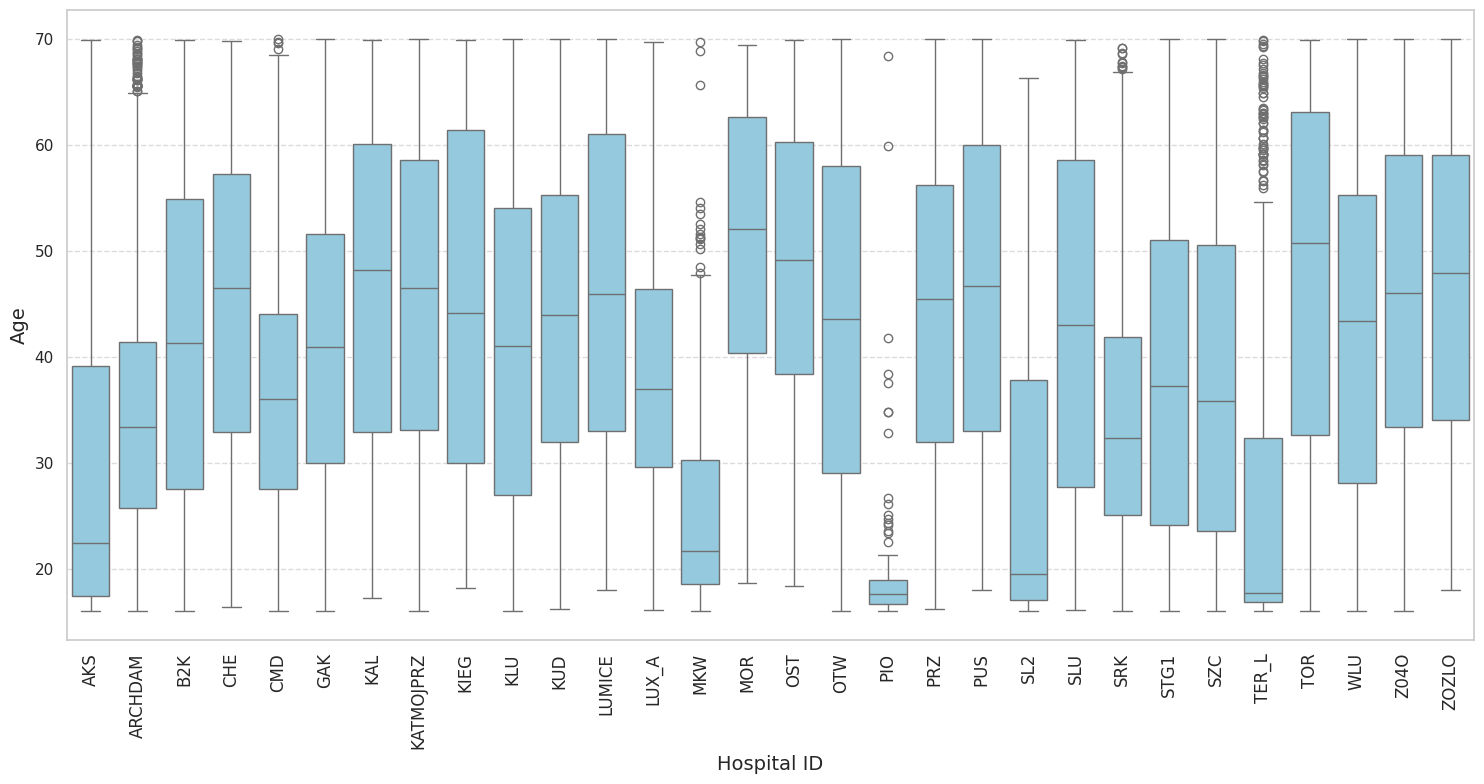

In [23]:
age_analysis = df.groupby('institution_id')['age_dec'].agg(['mean', 'median', 'std', 'min', 'max'])
print("\nStatistics for age by hospital:\n", age_analysis)

sns.set(style="whitegrid")

plt.figure(figsize=(15, 8))
sns.boxplot(x='institution_id', y='age_dec', data=df, order=sorted(df['institution_id'].unique()), color='skyblue')
#plt.title('Age Distribution by Hospital', fontsize=16, weight='bold')
plt.xlabel('Hospital ID', fontsize=14)
plt.ylabel('Age', fontsize=14)
plt.xticks(rotation=90, ha='center', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(results_folder, 'age_distribution_by_hospital_notitle.png'))
plt.show()

# Gender Analysis


Statistics for gender by hospital:
 patient_sex        Female       Male
institution_id                      
AKS             46.982759  53.017241
ARCHDAM         56.837047  43.162953
B2K             59.631902  40.368098
CHE             50.000000  50.000000
CMD             51.746032  48.253968
GAK             54.723127  45.276873
KAL             49.268293  50.731707
KATMOJPRZ       56.717587  43.282413
KIEG            50.909091  49.090909
KLU             42.471591  57.528409
KUD             56.198347  43.801653
LUMICE          43.710692  56.289308
LUX_A           57.578397  42.421603
MKW             38.396624  61.603376
MOR             52.475248  47.524752
OST             58.031838  41.968162
OTW             54.307841  45.692159
PIO             38.541667  61.458333
PRZ             42.069741  57.930259
PUS             49.397590  50.602410
SL2             60.000000  40.000000
SLU             60.040984  39.959016
SRK             63.392857  36.607143
STG1            38.758901  61.241099
S

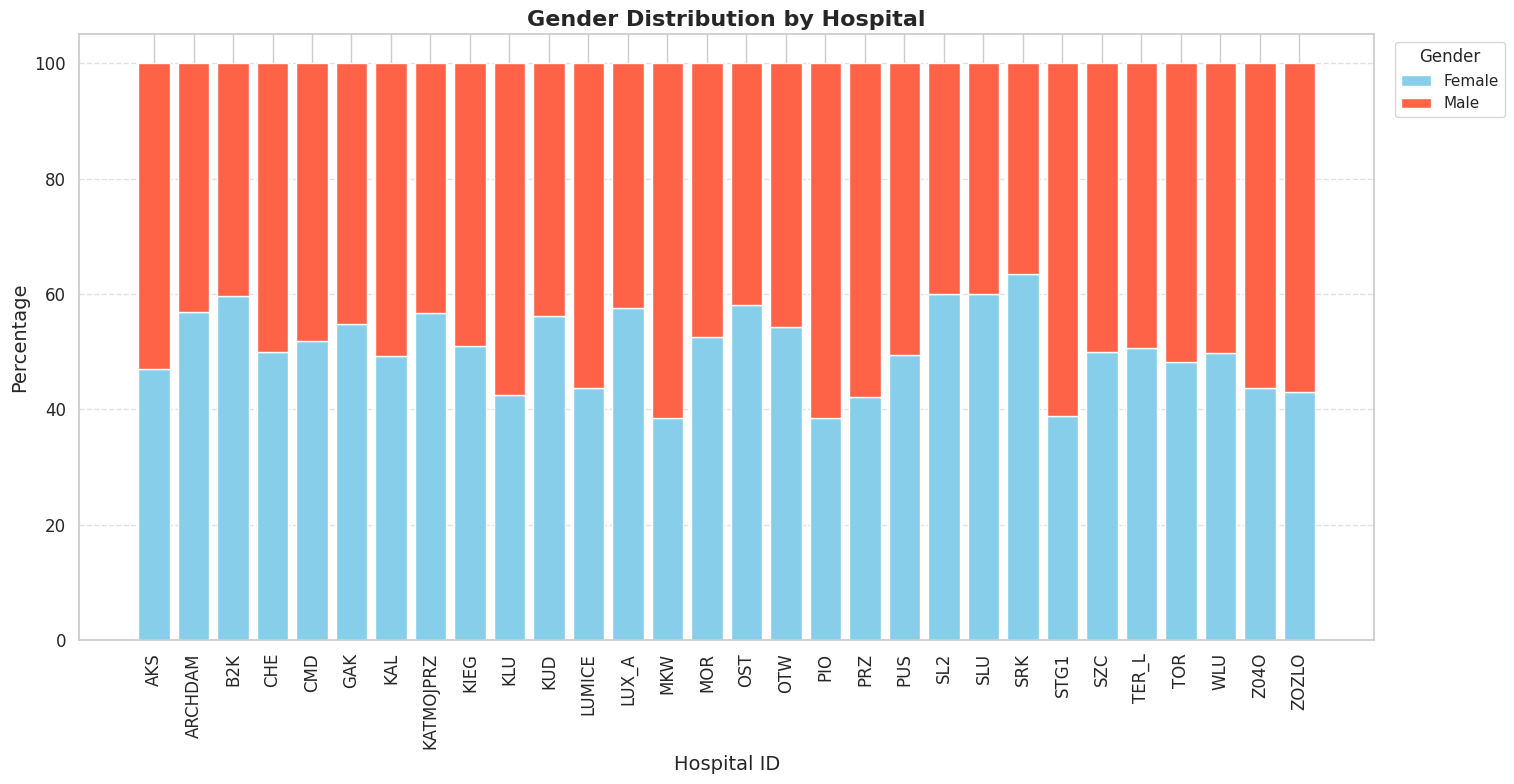

In [14]:
gender_counts = df.groupby(['institution_id', 'patient_sex']).size().reset_index(name='count')
gender_pivot = gender_counts.pivot(index='institution_id', columns='patient_sex', values='count').fillna(0)
gender_pivot['total'] = gender_pivot.sum(axis=1)
for col in gender_pivot.columns[:-1]:
    gender_pivot[col] = gender_pivot[col] / gender_pivot['total'] * 100
gender_pivot = gender_pivot.drop(['total'], axis=1)

print("\nStatistics for gender by hospital:\n", gender_pivot)

plt.figure(figsize=(14, 8))

bottom = np.zeros(len(gender_pivot))
colors = {'Female': 'skyblue', 'Male': 'tomato'}

for gender in ['Female', 'Male']:
    plt.bar(
        gender_pivot.index,
        gender_pivot[gender],
        bottom=bottom,
        label=gender,
        color=colors[gender]
    )
    bottom += gender_pivot[gender]

plt.ylabel('Percentage', fontsize=14)
plt.xlabel('Hospital ID', fontsize=14)
plt.xticks(rotation=90, ha='center', fontsize=12)
plt.title('Gender Distribution by Hospital', fontsize=16, weight='bold')
plt.yticks(fontsize=12)
plt.legend(title='Gender')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(title='Gender', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.savefig(os.path.join(results_folder, 'gender_distribution_by_hospital.png'), bbox_inches='tight')
plt.show()

# Fs Analysis

In [246]:
sfreq_stats = df['original_sfreq'].agg(['mean', 'median', 'std', 'min', 'max'])
print("\nDescriptive statistics for sampling frequency:\n", sfreq_stats)



Descriptive statistics for sampling frequency:
 mean      252.803321
median    250.000000
std        16.958140
min       249.978652
max       600.000000
Name: original_sfreq, dtype: float64


In [18]:
sum(abs(df['original_sfreq'] - 250) > 0.1)

7469


Descriptive statistics for sampling frequency by hospital:
                       mean      median        std         min         max
institution_id                                                           
AKS             251.419177  250.000000  21.704226  249.978652  600.000000
ARCHDAM         250.000000  250.000000   0.000000  250.000000  250.000000
B2K             250.000000  250.000000   0.000000  250.000000  250.000000
CHE             250.000000  250.000000   0.000000  250.000000  250.000000
CMD             250.000000  250.000000   0.000000  250.000000  250.000000
GAK             260.913706  250.000000  60.844312  250.000000  600.000000
KAL             250.000000  250.000000   0.000000  250.000000  250.000000
KATMOJPRZ       249.987501  249.987501   0.000000  249.987501  249.987501
KIEG            249.987501  249.987501   0.000000  249.987501  249.987501
KLU             249.998032  250.000000   0.002126  249.987501  250.000000
KUD             250.001843  250.002800   0.001329  

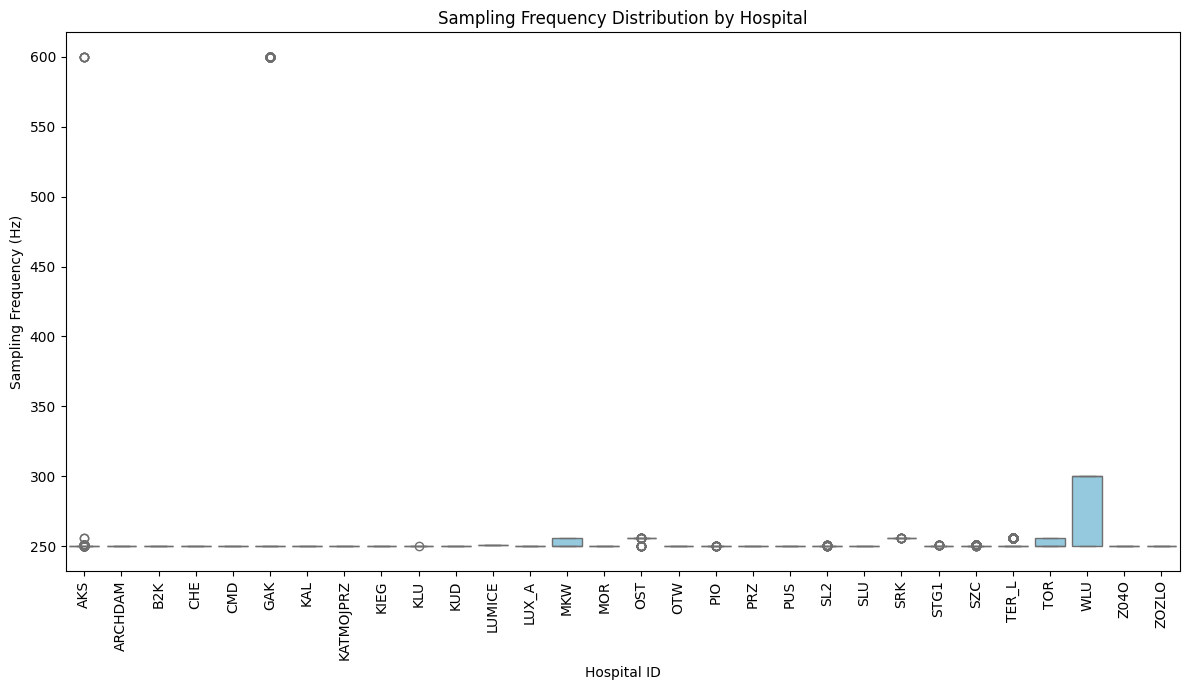

In [6]:
sfreq_stats = df.groupby('institution_id')['original_sfreq'].agg(['mean', 'median', 'std', 'min', 'max'])
print("\nDescriptive statistics for sampling frequency by hospital:\n", sfreq_stats)

# Wykres
plt.figure(figsize=(12, 7))
sns.boxplot(x='institution_id', y='original_sfreq', data=df, order=sorted(df['institution_id'].unique()), color='skyblue')
plt.title('Sampling Frequency Distribution by Hospital')
plt.xlabel('Hospital ID')
plt.ylabel('Sampling Frequency (Hz)')
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.show()


Descriptive statistics for high-pass filter by hospital:
                     mean  median       std   min   max
institution_id                                        
AKS             0.006296    0.00  0.031121  0.00  0.16
AND             0.094815    0.16  0.079106  0.00  0.16
ARCHDAM         0.000000    0.00  0.000000  0.00  0.00
B123            0.000000    0.00  0.000000  0.00  0.00
B21             0.035294    0.00  0.066836  0.00  0.16
B2K             0.000000    0.00  0.000000  0.00  0.00
BIL             0.000000    0.00  0.000000  0.00  0.00
CHE             0.000000    0.00  0.000000  0.00  0.00
CMD             0.000000    0.00  0.000000  0.00  0.00
DZI             0.053333    0.00  0.092376  0.00  0.16
GAK             0.000000    0.00  0.000000  0.00  0.00
KAL             0.000000    0.00  0.000000  0.00  0.00
KATMOJPRZ       0.160000    0.16  0.000000  0.16  0.16
KIEG            0.157957    0.16  0.018000  0.00  0.16
KLU             0.074680    0.00  0.079848  0.00  0.16
KUD   

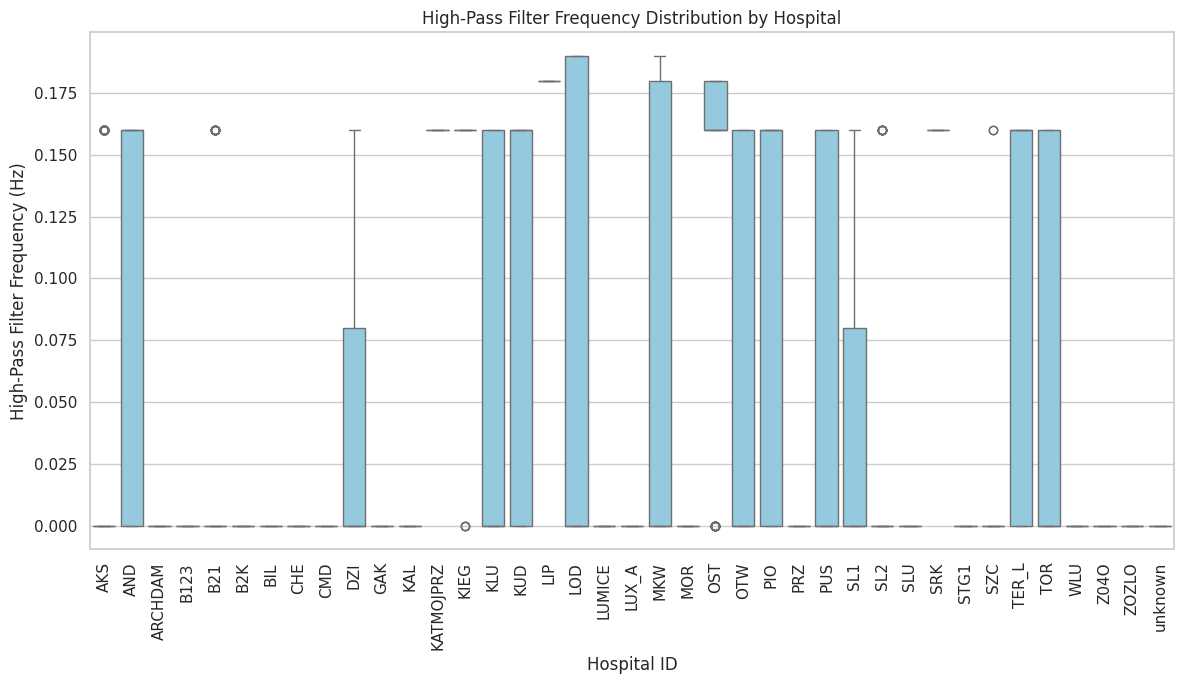

In [248]:
highpass_stats = df.groupby('institution_id')['highpass_filter_acq'].agg(['mean', 'median', 'std', 'min', 'max'])
print("\nDescriptive statistics for high-pass filter by hospital:\n", highpass_stats)

plt.figure(figsize=(12, 7))
sns.boxplot(
    x='institution_id',
    y='highpass_filter_acq',
    data=df,
    order=sorted(df['institution_id'].unique()),
    color='skyblue'
)
plt.title('High-Pass Filter Frequency Distribution by Hospital')
plt.xlabel('Hospital ID')
plt.ylabel('High-Pass Filter Frequency (Hz)')
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.show()


Descriptive statistics for low-pass filter by hospital:
                       mean     median         std    min         max
institution_id                                                      
AKS             125.691358  125.00000   40.096477   97.0  1500.00000
AND             108.407407   97.00000   13.843571   97.0   125.00000
ARCHDAM         125.000000  125.00000    0.000000  125.0   125.00000
B123            125.043165  125.00000    0.140934  125.0   125.50000
B21             120.227941  125.00000    9.267756   97.0   125.50000
B2K             125.000000  125.00000    0.000000  125.0   125.00000
BIL             125.000000  125.00000    0.000000  125.0   125.00000
CHE             125.000000  125.00000    0.000000  125.0   125.00000
CMD             125.000000  125.00000    0.000000  125.0   125.00000
DZI             118.000000  125.00000   12.124356  104.0   125.00000
GAK             130.456853  125.00000   30.422156  125.0   300.00000
KAL             125.000000  125.00000    0.00

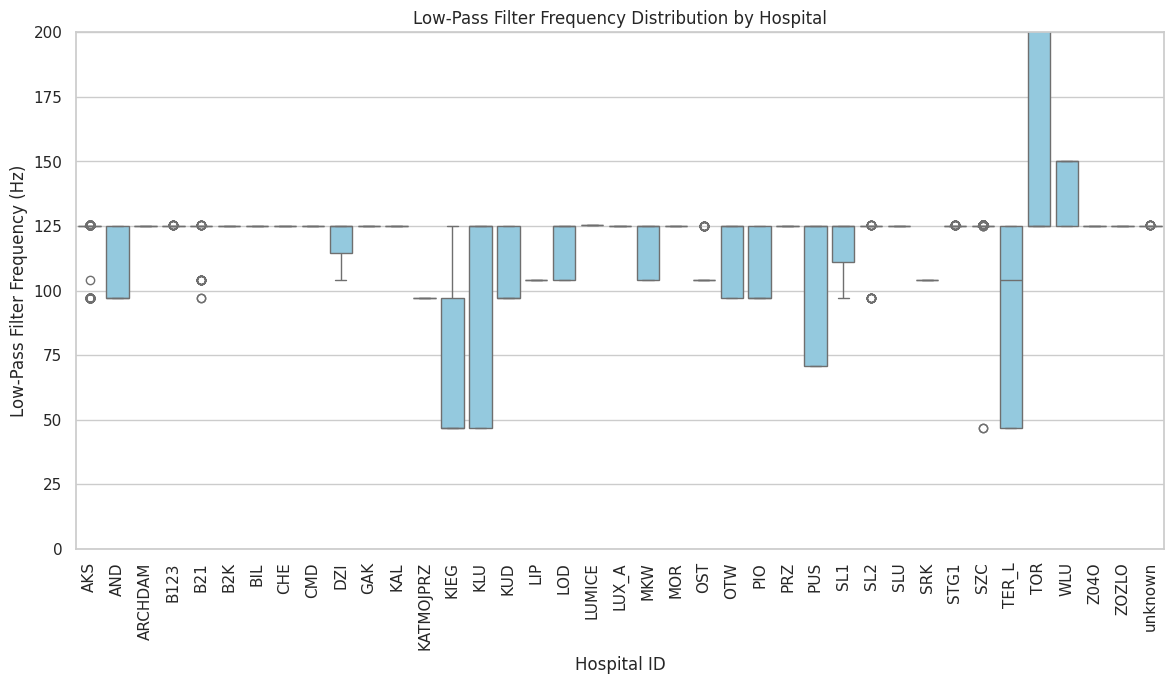

In [249]:
lowpass_stats = df.groupby('institution_id')['lowpass_filter_acq'].agg(['mean', 'median', 'std', 'min', 'max'])
print("\nDescriptive statistics for low-pass filter by hospital:\n", lowpass_stats)

plt.figure(figsize=(12, 7))
sns.boxplot(
    x='institution_id',
    y='lowpass_filter_acq',
    data=df,
    order=sorted(df['institution_id'].unique()),
    color='skyblue'
)
plt.title('Low-Pass Filter Frequency Distribution by Hospital')
plt.xlabel('Hospital ID')
plt.ylabel('Low-Pass Filter Frequency (Hz)')
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.ylim(0, 200)
plt.show()


# Recording duration analysis


Descriptive statistics for low-pass filter by hospital:
                    mean   median      std      min      max
institution_id                                             
AKS             1423.16  1210.00   694.90   774.00  4635.23
ARCHDAM         1433.89  1235.00   599.39   765.00  5620.00
B2K              928.45   906.00   107.90   606.00  1392.00
CHE              944.44   928.50   267.94   342.00  1701.00
CMD             1434.49  1235.00   611.01   785.00  4085.00
GAK             1114.57  1206.00   124.17   875.00  1230.00
KAL             1299.85  1215.00   433.60   375.00  3665.00
KATMOJPRZ       1236.52  1212.06   169.56   642.03  8322.42
KIEG            1146.71  1206.06   706.37   396.02  7992.40
KLU             1184.02  1195.02   103.01   930.00  2585.04
KUD             1254.27  1218.00   138.11  1204.99  3606.00
LUMICE          1921.79  1890.00   138.58  1500.00  2646.00
LUX_A           1226.05  1212.00    71.78   906.00  2412.00
MKW              997.44   966.00   226.02 

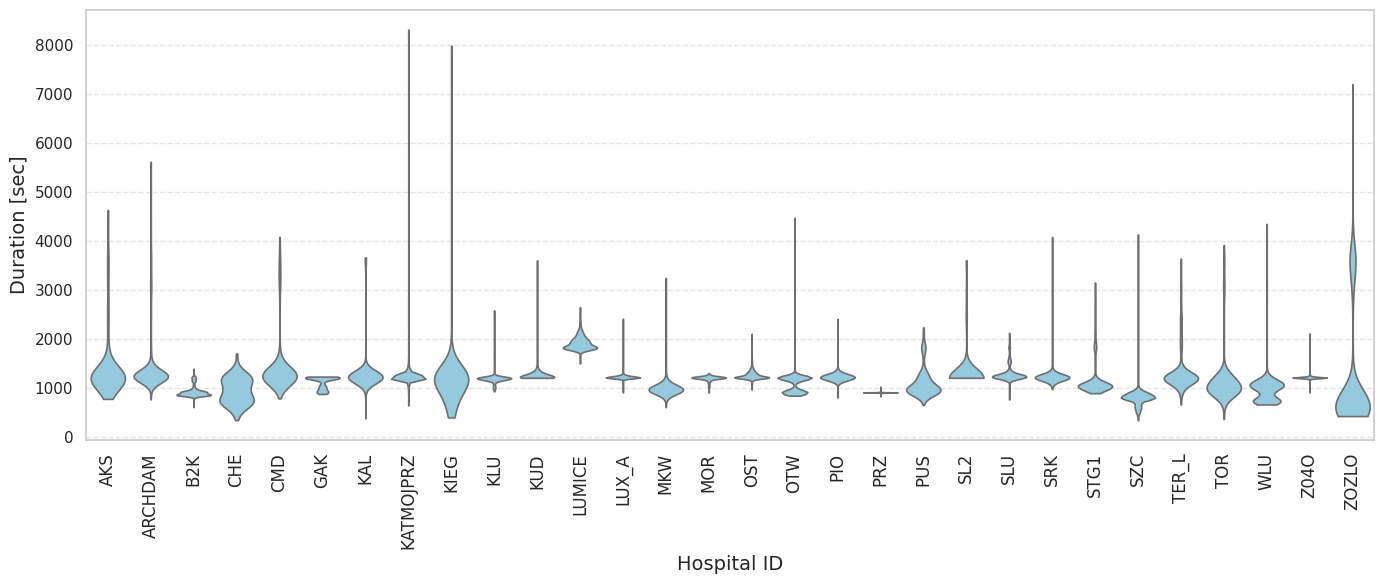

In [21]:
lowpass_stats = df.groupby('institution_id')['duration_sec'].agg(['mean', 'median', 'std', 'min', 'max'])
print("\nDescriptive statistics for low-pass filter by hospital:\n", lowpass_stats.round(2))

plt.figure(figsize=(14, 6))
sns.violinplot(
    x='institution_id',
    y='duration_sec',
    data=df,
    order=sorted(df['institution_id'].unique()),
    inner=None,       
    color='skyblue',
    cut=0,              
    linewidth=1.2,
    density_norm='width',          
    width=0.8
)

plt.title('Distribution of EEG Recording Durations Across Institutions', fontsize=16, weight='bold')
plt.xlabel('Hospital ID', fontsize=14)
plt.ylabel('Duration [sec]', fontsize=14)
plt.xticks(rotation=90, ha='center', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(os.path.join(results_folder, 'recording_duration_by_hospital_notitle.png'))
plt.show()


# Norm + Patho Dataset

In [25]:
df = pd.read_csv('datasets/ELM19/filtered/ELM19_enriched_info_filtered.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52660 entries, 0 to 52659
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   examination_id       52660 non-null  object 
 1   patient_original_id  52660 non-null  object 
 2   age_dec              52660 non-null  float64
 3   patient_sex          52660 non-null  object 
 4   institution_id       52660 non-null  object 
 5   classification       52660 non-null  object 
 6   original_sfreq       52660 non-null  float64
 7   n_channels_original  52660 non-null  int64  
 8   highpass_filter_acq  52660 non-null  float64
 9   lowpass_filter_acq   52660 non-null  float64
 10  n_samples            52660 non-null  int64  
 11  duration_sec         52660 non-null  float64
 12  recording_date       52660 non-null  object 
 13  specialist_hospital  36519 non-null  object 
 14  children_hospital    36519 non-null  object 
 15  software             31925 non-null 

# Recording Count - Norm vs Patho


Statistics for gender by hospital:
 classification   norm
institution_id       
AKS             100.0
ARCHDAM         100.0
B2K             100.0
CHE             100.0
CMD             100.0
GAK             100.0
KAL             100.0
KATMOJPRZ       100.0
KIEG            100.0
KLU             100.0
KUD             100.0
LUMICE          100.0
LUX_A           100.0
MKW             100.0
MOR             100.0
OST             100.0
OTW             100.0
PIO             100.0
PRZ             100.0
PUS             100.0
SL2             100.0
SLU             100.0
SRK             100.0
STG1            100.0
SZC             100.0
TER_L           100.0
TOR             100.0
WLU             100.0
Z04O            100.0
ZOZLO           100.0


KeyError: 'patho'

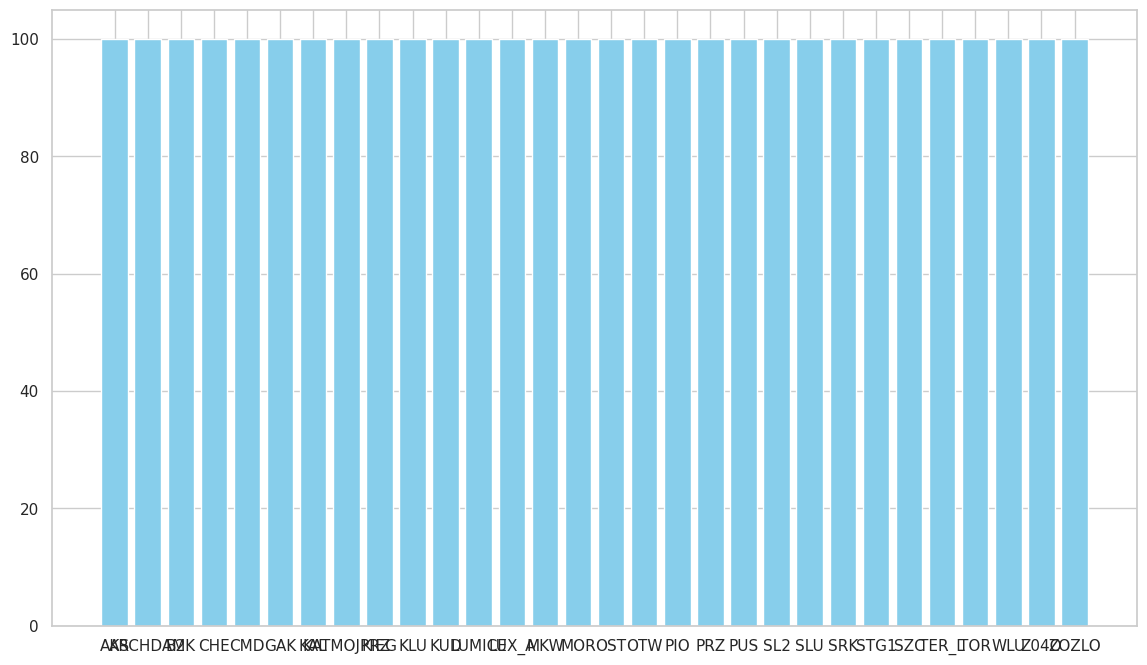

In [22]:
class_counts = df.groupby(['institution_id', 'classification']).size().reset_index(name='count')
class_pivot = class_counts.pivot(index='institution_id', columns='classification', values='count').fillna(0)
class_pivot['total'] = class_pivot.sum(axis=1)
for col in class_pivot.columns[:-1]:
    class_pivot[col] = class_pivot[col] / class_pivot['total'] * 100
class_pivot = class_pivot.drop(['total'], axis=1)

print("\nStatistics for gender by hospital:\n", class_pivot)

plt.figure(figsize=(14, 8))

# Słupki stacked
bottom = np.zeros(len(class_pivot))  # starty dla stacking
colors = {'norm': 'skyblue', 'patho': 'tomato'}

for cls in ['norm', 'patho']:
    plt.bar(
        class_pivot.index,
        class_pivot[cls],
        bottom=bottom,
        label=cls,
        color=colors[cls]
    )
    bottom += class_pivot[cls]

plt.ylabel('Percentage', fontsize=14)
plt.xlabel('Hospital ID', fontsize=14)
plt.xticks(rotation=90, ha='center', fontsize=12)
#plt.title('Distribution of Clinical Labels by Institution', fontsize=16, weight='bold')
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(title='Clinical Label', bbox_to_anchor=(1.01, 1), loc='upper left')
#plt.savefig(os.path.join(results_folder, 'clinical_label_distribution_by_hospital_notitle.png'))
plt.show()

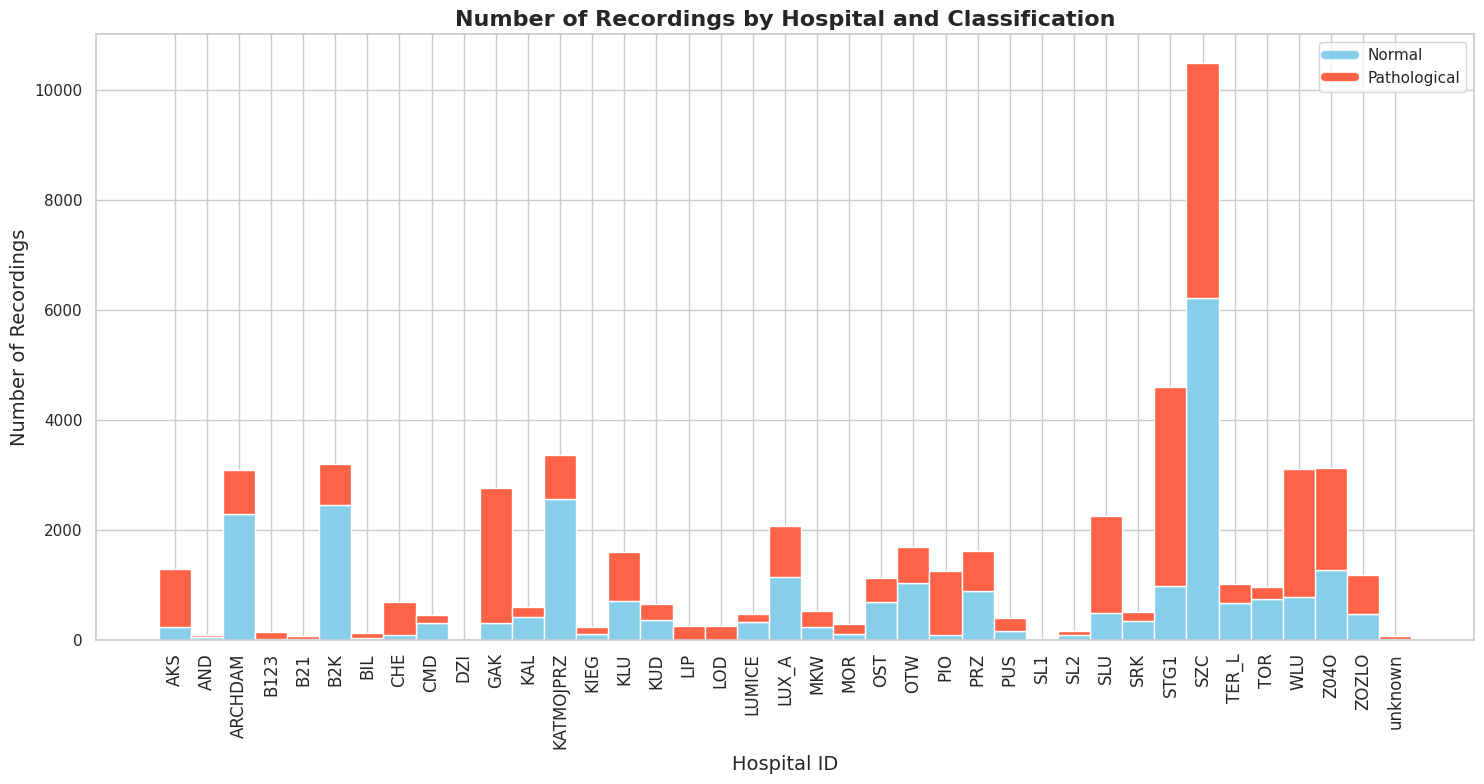

In [14]:
class_counts = df.groupby(['institution_id', 'classification']).size().unstack(fill_value=0)
class_counts = class_counts.sort_index()

norm_colors = 'skyblue'
patho_color = 'tomato'

x = np.arange(len(class_counts))
width = 1

fig, ax = plt.subplots(figsize=(15, 8))

norm_bars = ax.bar(x, class_counts['norm'], width, color=norm_colors, label='Normal')
patho_bars = ax.bar(x, class_counts['patho'], width, bottom=class_counts['norm'], color=patho_color, label='Pathological')

ax.set_xlabel('Hospital ID', fontsize=14)
ax.set_ylabel('Number of Recordings', fontsize=14)
ax.set_title('Number of Recordings by Hospital and Classification', fontsize=16, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_counts.index, rotation=90, ha='center', fontsize=12)

handles = [
    plt.Line2D([0], [0], color=norm_colors, lw=6, label='Normal'),
    plt.Line2D([0], [0], color=patho_color, lw=6, label='Pathological')
]
ax.legend(handles=handles, loc='upper right')
plt.tight_layout()
#plt.savefig(os.path.join(results_folder, 'ELM19_recordings_by_hospital_and_classification_t.png'))
plt.show()

In [252]:
grouped_counts = elm19_info.groupby(['institution_id', 'classification']).size().unstack(fill_value=0)
grouped_counts['sum'] = grouped_counts['norm'] + grouped_counts['patho']

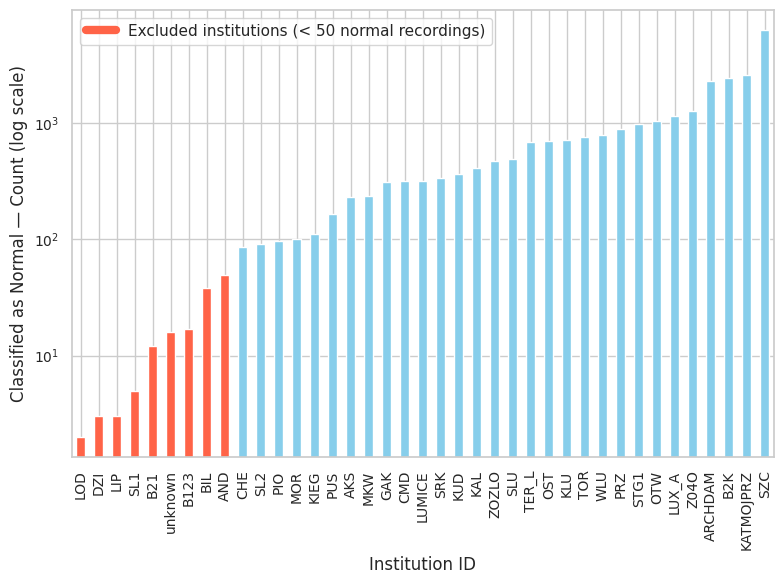

In [253]:
# Prepare the data
df = grouped_counts.reset_index().sort_values(by="norm").reset_index(drop=True)

# Define the threshold
threshold = 50

# Assign colors based on the threshold
colors = ['skyblue' if val >= threshold else 'tomato' for val in df['norm']]
hospitals_above_threshold = grouped_counts[grouped_counts['norm'] >= threshold].index.tolist()

# Create the plot
ax = df.plot(
    x='institution_id',
    y='norm',
    kind='bar',
    figsize=(8, 6),
    legend=False,
    color=colors,
    logy=True
)

# Add titles and labels
plt.xlabel("Institution ID", fontsize=12)
plt.ylabel("Classified as Normal — Count (log scale)", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)


# Add legend manually
handles = [
    plt.Line2D([0], [0], color='tomato', lw=6, label=f'Excluded institutions (< {threshold} normal recordings)'),
]
plt.legend(handles=handles)

# Tidy layout
plt.tight_layout()

#plt.savefig(results_folder+"/ELM19_excluded_institutions_normal_recordings.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

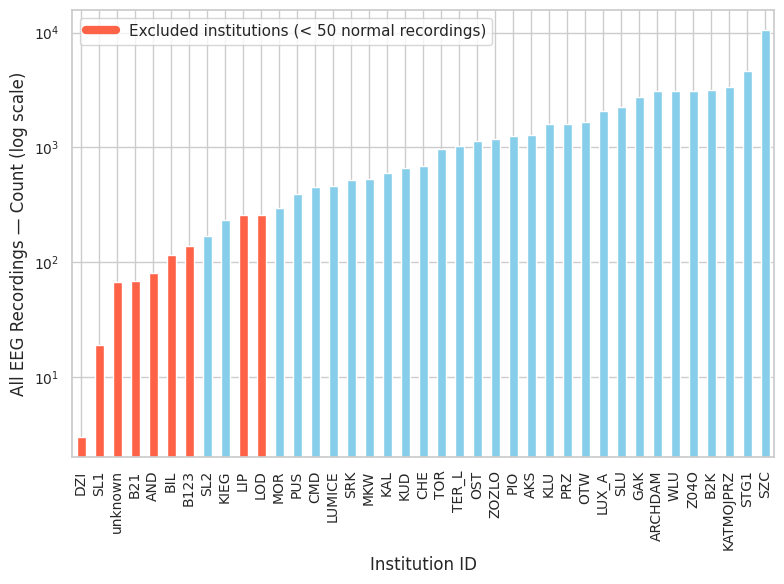

In [254]:
import matplotlib.pyplot as plt

# Prepare the data
df = grouped_counts.reset_index().sort_values(by="sum").reset_index(drop=True)

colors = ['skyblue' if hospital in hospitals_above_threshold else 'tomato' for hospital in df['institution_id']]
# Create the plot
ax = df.plot(
    x='institution_id',
    y='sum',
    kind='bar',
    figsize=(8, 6),
    legend=False,
    color=colors,
    logy=True
)

# Add titles and labels
plt.xlabel("Institution ID", fontsize=12)
plt.ylabel("All EEG Recordings — Count (log scale)", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)


# Add legend manually
handles = [
    plt.Line2D([0], [0], color='tomato', lw=6, label=f'Excluded institutions (< {threshold} normal recordings)'),
]
plt.legend(handles=handles)

# Tidy layout
plt.tight_layout()

#plt.savefig(results_folder+"/ELM19_excluded_institutions_all_recordings.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

# Additional info

In [11]:
hospitals = elm19_info['institution_id'].unique()

In [12]:
df_hardware = pd.read_excel("datasets/ELM19/Lista_baz_informacje.xlsx")
df_hardware = df_hardware.drop(['Oryginalna liczba badań (plików)', 'Lp.'], axis=1)
df_hardware = df_hardware.rename(columns={
    'ID': 'institution_id',
    'Oryginalna liczba badań (plików)': 'num_records',
    'Szpital Specjalistyczny [TAK] czy [NIE]?': 'specialist_hospital',
    'Szpital dziecięcy [TAK] lub [NIE]': 'children_hospital',
    'Software': 'software',
    'Hardware': 'hardware',
    'Specjalizacja': 'specialization',
})

df_hardware['specialist_hospital'] = df_hardware['specialist_hospital'].map({'TAK': True, 'NIE': False})
df_hardware['children_hospital'] = df_hardware['children_hospital'].map({'TAK': True, 'NIE': False})

df_hardware = df_hardware[df_hardware['institution_id'].isin(hospitals)]

In [13]:
def parse_specialization(text):
    if pd.isna(text):
        return []
    items = [line.strip() for line in text.split('\n') if line.strip() != '']
    items = [item.lstrip('- ').strip() for item in items]
    return items

df_hardware['specialization'] = df_hardware['specialization'].apply(parse_specialization)

In [14]:
df_hardware['hardware'] = df_hardware['hardware'].replace({'--': np.nan})
df_hardware['software'] = df_hardware['software'].replace(['--', 'nie mam informacji', 'NaN', ''], np.nan)

/tmp/ipykernel_26965/3451927456.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_hardware['hardware'] = df_hardware['hardware'].replace({'--': np.nan})


In [15]:
df_hardware.loc[df_hardware['institution_id'] == 'LIP', 'software'] = np.nan
df_hardware.loc[df_hardware['institution_id'] == 'SZC', 'software'] = 6
df_hardware.loc[df_hardware['institution_id'] == 'SRK', 'software'] = 12
df_hardware.loc[df_hardware['institution_id'] == 'KLU', 'software_dates'] = '[09.02.2016, 26.09.2017]'
df_hardware.loc[df_hardware['institution_id'] == 'KLU', 'software'] = '[6.90.3.1, 10.3.8.1, 14.0.2.5]'
df_hardware.loc[df_hardware['institution_id'] == 'OST', 'software_dates'] = '[13.12.2018]'
df_hardware.loc[df_hardware['institution_id'] == 'OST', 'software'] = '[12.2.1.2, 14.1.1.1]'
df_hardware.loc[df_hardware['institution_id'] == 'KIEG', 'software_dates'] = '[08.09.2020]'
df_hardware.loc[df_hardware['institution_id'] == 'KIEG', 'software'] = '[10.3.8.1, 15.0.4.0]'

In [16]:
df_hardware

,institution_id,specialist_hospital,specialization,children_hospital,software,hardware,software_dates
2,LIP,False,[],False,NaN,1042.0,NaN
3,SZC,False,[],False,6,1032.0,NaN
4,CHE,True,"[Chirurgia ogólna i ortopedia, Kardiologia i p...",False,6.90.0.8,1032.0,NaN
5,BIL,False,[],False,6.90.3.1,1032.0,NaN
6,DZI,True,[],True,6.90.3.1,1032.0,NaN
10,B21,NaN,[],NaN,NaN,NaN,NaN
11,SL1,NaN,[],NaN,NaN,NaN,NaN
12,SL2,NaN,[],NaN,NaN,NaN,NaN
13,PUS,False,[],False,6.82,1032.0,NaN
15,CMD,NaN,[],NaN,NaN,NaN,NaN


In [17]:
def parse_software_versions(s):
    s = str(s)
    if pd.isna(s) or s == 'nan':
        return []
    s = s.strip('[]')
    if not s:
        return []
    return [x.strip() for x in s.split(',')]


In [31]:
df_hardware = df_hardware.drop_duplicates(subset='institution_id', keep='last')


In [32]:
elm19_enriched_2_info = pd.merge(elm19_enriched_info, df_hardware.drop(['specialization'], axis=1), on='institution_id', how='left')
elm19_enriched_2_info['recording_date'] = pd.to_datetime(elm19_enriched_2_info['recording_date'], errors='coerce')

In [33]:
elm19_enriched_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55787 entries, 0 to 55786
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   examination_id       55787 non-null  object 
 1   patient_original_id  55787 non-null  object 
 2   age_dec              55787 non-null  float64
 3   patient_sex          55787 non-null  object 
 4   institution_id       55787 non-null  object 
 5   classification       55787 non-null  object 
 6   original_sfreq       55787 non-null  float64
 7   n_channels_original  55787 non-null  int64  
 8   highpass_filter_acq  55787 non-null  float64
 9   lowpass_filter_acq   55787 non-null  float64
 10  n_samples            55787 non-null  int64  
 11  duration_sec         55787 non-null  float64
 12  recording_date       55787 non-null  object 
dtypes: float64(5), int64(2), object(6)
memory usage: 5.5+ MB


In [34]:

software_for_recording = []

for i, row in elm19_enriched_2_info.iterrows():
    software_versions = parse_software_versions(row['software'])
    software_dates = parse_software_versions(row['software_dates'])
    # zamieniamy daty na datetime (jeśli to stringi)
    software_dates_dt = pd.to_datetime(software_dates, errors='coerce', dayfirst=True)

    # domyślnie brak wersji dopasowanej
    matched_version = None

    if len(software_versions) == 1 or len(software_dates_dt) == 0:
        # jeśli jest tylko jedna wersja lub brak dat, bierzemy pierwszą lub nan
        matched_version = software_versions[0] if software_versions else None
    else:
        # jeśli jest wiele wersji i dat
        for ver, dt in sorted(zip(software_versions, software_dates_dt), key=lambda x: x[1]):
            if pd.isna(row['recording_date']):
                matched_version = None
                break
            if row['recording_date'] <= dt:
                matched_version = ver
                break
        if matched_version is None:
            # jeśli data nagrania jest późniejsza niż wszystkie daty, weź ostatnią wersję
            matched_version = software_versions[-1]

    software_for_recording.append(matched_version)

elm19_enriched_2_info['software'] = software_for_recording
elm19_enriched_2_info = elm19_enriched_2_info.drop(["software_dates"], axis=1)

In [35]:
elm19_enriched_2_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55787 entries, 0 to 55786
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   examination_id       55787 non-null  object        
 1   patient_original_id  55787 non-null  object        
 2   age_dec              55787 non-null  float64       
 3   patient_sex          55787 non-null  object        
 4   institution_id       55787 non-null  object        
 5   classification       55787 non-null  object        
 6   original_sfreq       55787 non-null  float64       
 7   n_channels_original  55787 non-null  int64         
 8   highpass_filter_acq  55787 non-null  float64       
 9   lowpass_filter_acq   55787 non-null  float64       
 10  n_samples            55787 non-null  int64         
 11  duration_sec         55787 non-null  float64       
 12  recording_date       55787 non-null  datetime64[ns]
 13  specialist_hospital  38925 non-

In [36]:
elm19_enriched_2_info.to_csv('datasets/ELM19/ELM19_enriched_2_info.csv',  index=False)